In [2]:
import sys
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import snntorch
import torch
from matplotlib import cm
from snntorch import surrogate

sys.path.append('../')
from src import data
from src.spiking_neural_network import Snn
from src import pci
from src import plot_params

In [11]:
def pci_alpha(
        model: Snn,
        checkpoint: dict,
        frames: list,
        alpha: np.ndarray,
        device: str
) -> np.ndarray:
    """ Get the PCI in function of stimulus stength alpha for each layer.
    """
    
    num_frames = len(frames)
    num_hidden_layers = model.num_layers - 1
    pci_layers = np.zeros((num_hidden_layers, alpha.shape[0], num_frames))
    for idx, a in enumerate(alpha):
        frames_alpha = [frame*a for frame in frames]

        layers = model.movie(checkpoint, frames_alpha, device)

        layer_1 = np.zeros((num_frames, 3, model.num_units_layers[1]))
        layer_2 = np.zeros((num_frames, 3, model.num_units_layers[2]))

        for t in range(num_frames):
            layer_1[t,:] = layers[t][0][:]
            layer_2[t,:] = layers[t][1][:]


        # spk1 = np.concatenate(layer_1[:, 0,:, :], axis=0)
        # spk2 = np.concatenate(layer_2[:, 0,:, :], axis=0)

        spk_1 = layer_1[:,0,:]
        spk_2 = layer_2[:,0,:]

        pci_layers[0,idx,:] = pci.calculate(spk_1.T.astype(int))
        pci_layers[1,idx,:] = pci.calculate(spk_2.T.astype(int))

        print(idx, '/', len(alpha))
        
    return pci_layers

In [3]:
database = 'mnist'
batch_size = 128

train_set, test_set, train_loader, test_loader, device = data.set_loader_device(database, batch_size)

set_name = 'test_set'
imgs_labels = torch.load(
    f'../data/imgs_labels/{database}_{set_name}_imgs_labels.pth')

In [6]:
num_units_layers = [784, 300, 300, 10]
spk_neuron = snntorch.Leaky(beta=0.5,
                            threshold=1,
                            reset_mechanism='subtract',
                            spike_grad=surrogate.fast_sigmoid(slope=25))

model = Snn(spk_neuron, num_units_layers).to(device=device)
checkpoint = torch.load(f'../data/trained_model/300_300_{database}_snn.pth')

In [9]:
def fast_transition_movie(imgs_labels: list, delta_t: int):
    frames = list()
    labels = np.random.randint(10, size=200)
    for l in labels:
        # We randomly choice samples over dataset.
        samples = np.random.randint(800, size=delta_t)
        for t in samples:
            frames +=  [imgs_labels[str(l)][t]]

    return frames 

frames = fast_transition_movie(imgs_labels, delta_t=25)
num_frames = len(frames)
print('num_frames', num_frames)

num_frames 5000


In [12]:
alpha = np.arange(0,1.05,0.05)
pci_layers = pci_alpha(model, checkpoint, frames, alpha, device)

0 / 21
1 / 21
2 / 21
3 / 21
4 / 21
5 / 21
6 / 21
7 / 21
8 / 21
9 / 21
10 / 21
11 / 21
12 / 21
13 / 21
14 / 21
15 / 21
16 / 21
17 / 21
18 / 21
19 / 21
20 / 21


In [14]:
def plot_pci_frames_alpha(pci_layers, layer, save=False):

    t = np.arange(pci_layers.shape[2])
    a = alpha[:]
    X, Y = np.meshgrid(t, a)
    Z = pci_layers[layer, :, :]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.plot_surface(X, Y, Z, cmap=cm.viridis, rstride=1, cstride=1)
    ax.plot_wireframe(X, Y, Z, rstride=2, cstride=90, color='black')

    ax.set_box_aspect(aspect=None, zoom=0.8)

    ax.set_xlabel(r'$t$', labelpad=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_ylabel(r'$\alpha$', labelpad=20)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_zlabel('PCI', labelpad=15, rotation=90)

    ax.view_init(elev=15, azim=160, roll=0)

    if save == True:
        fig.savefig(f'../plots/07_pci_anesthesia/pci_frames_alpha_{layer}.png')

    plt.show()

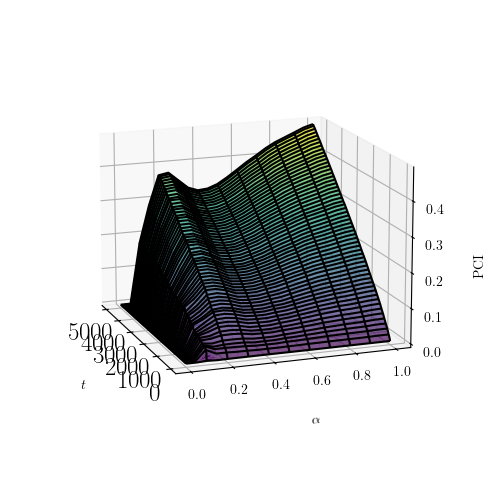

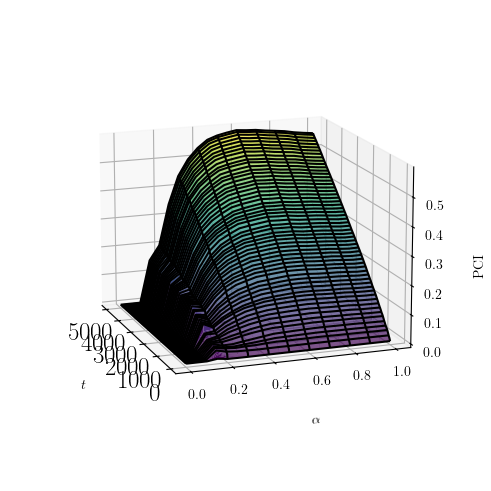

In [15]:
plot_pci_frames_alpha(pci_layers, 0)
plot_pci_frames_alpha(pci_layers, 1)

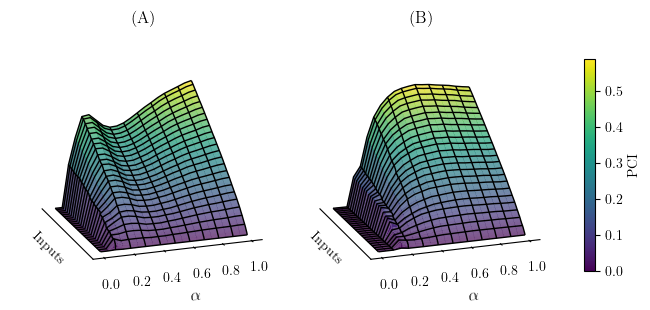

In [103]:
t = np.arange(pci_layers.shape[2])
a = alpha[:]
X, Y = np.meshgrid(t, a)
Z = pci_layers[0, :, :]

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

ax.plot_surface(X, Y, Z, cmap=cm.viridis, rstride=1, cstride=1)
ax.plot_wireframe(X, Y, Z, rstride=2, cstride=220, color='black', linewidth=1)

#ax.set_box_aspect(aspect=None, zoom=0.8)

ax.set_xlabel(r'Inputs', fontsize=10, labelpad=-10)
ax.set_xticks([])
#ax.tick_params(axis='x', labelsize=18)
ax.set_ylabel(r'$\alpha$', fontsize=12)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_zticks([])
#ax.set_zlabel('PCI', rotation=90)

ax.view_init(elev=15, azim=160, roll=0)


Z = pci_layers[1, :, :]

#fig = plt.figure()
ax_1 = fig.add_subplot(122, projection='3d')

plot = ax_1.plot_surface(X, Y, Z, cmap=cm.viridis, rstride=1, cstride=1)
ax_1.plot_wireframe(X, Y, Z, rstride=2, cstride=220, color='black',linewidth=1)

#ax_1.set_box_aspect(aspect=None, zoom=0.8)

ax_1.set_xlabel(r'Inputs', fontsize=10, labelpad=-10)
ax_1.set_xticks([])
#ax_1.tick_params(axis='x', labelsize=18)
ax_1.set_ylabel(r'$\alpha$', fontsize=12)
# ax_1.set_yticklabels(ax.get_yticks(),)
ax_1.set_ylim(ax_1.get_ylim()[::-1])
ax_1.set_zticks([])
#ax_1.set_zlabel('PCI', rotation=90)
ax.grid(False)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_label_position('none')
ax.zaxis.set_ticks_position('none')

ax_1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax_1.zaxis.set_label_position('none')
ax_1.zaxis.set_ticks_position('none')
ax_1.grid(False)
ax_1.view_init(elev=15, azim=160, roll=0)
ax_1.set_facecolor('white')
cbar1 = fig.colorbar(plot, ax=ax_1, pad=0.1, shrink=0.45, label='PCI')

ax_1.set_title('(B)')
ax.set_title('(A)')
ax.tick_params(axis='x', which='major', pad=-10)
# if save == True:
#     fig.savefig(f'../plots/07_pci_anesthesia/pci_frames_alpha_{layer}.png')

# plt.subplots_adjust(wspace=2, hspace=2)

# fig.savefig(f'../plots/pci_anesthesia.pdf')
# fig.savefig(f'../plots/pci_anesthesia.png', dpi=300)
plt.show()
